#  Прогнозирование заказов такси

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

Отсортируем датафрейм по индексам.

In [5]:
data.sort_index(inplace=True)

In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Применим ресемплирование по часам.

In [7]:
data = data.resample('1H').sum()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


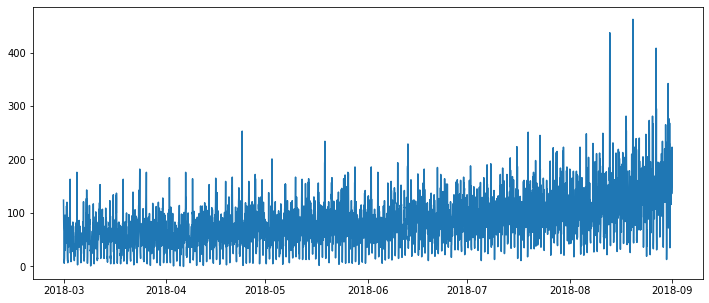

In [8]:
plt.figure(figsize=(12,5))
plt.plot(data);

## Анализ

Сделаем декомпозицию по целевому признаку и рассмотрим все три составляющие отдельно:

- тренд;
- сезонная составляющая;
- остаток декомпозиции.

In [9]:
decomposed = seasonal_decompose(data['num_orders'])

Применим скользящее среднее, чтобы оценить тренд.

- Тренд:

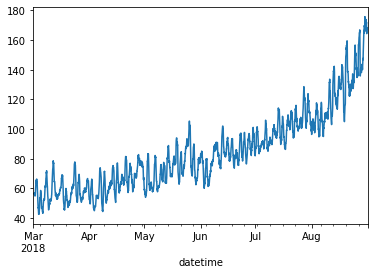

In [11]:
decomposed.trend.plot();

С марта по сентябрь число заказов увеличивается. Видимо сервис становится популярнее.

- Сезонность:

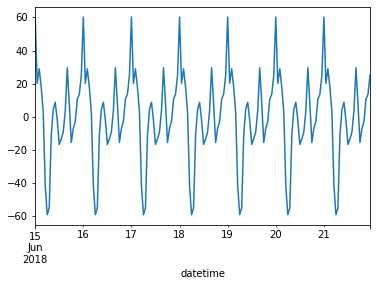

In [12]:
decomposed.seasonal['2018-06-15':'2018-06-21'].plot();

Мы видим, что количество заказов зависит от времени суток. 

In [13]:
#plt.figure(figsize=(12,5))
#plt.title('Скользящее среднее')
#plt.plot(data)
#plt.show()

Оценим сезонность в разные недели имеющегося временного промежутка.

In [14]:
"""
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False)
fig.suptitle('Сезонность в заказах в разные недели')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
week1 = decomposed.seasonal['2018-03-15':'2018-03-21']
week1.plot(kind='line',figsize=(15, 15), ax=ax1, grid=True)
week2 = decomposed.seasonal['2018-06-15':'2018-06-21']
week2.plot(kind='line',figsize=(15, 15), ax=ax2, grid=True)
week3 = decomposed.seasonal['2018-08-15':'2018-08-21']
week3.plot(kind='line',figsize=(15, 15), ax=ax3, grid=True)

ax1.set_title("['2018-03-15':'2018-03-21']")
ax1.set(xlabel='Время', ylabel='Заказы')
ax2.set_title("['2018-06-15':'2018-06-21']")
ax2.set(xlabel='Время', ylabel='Заказы')
ax3.set_title("['2018-08-15':'2018-08-21']")
ax3.set(xlabel='Время', ylabel='Заказы')

plt.show()
""";

- Остатки (шум):

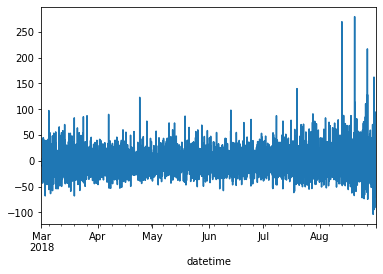

In [15]:
decomposed.resid.plot();

Чтобы получить из исходного ряда стационарный, найдём разности его значений.

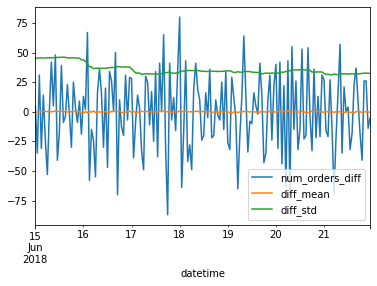

In [16]:
data['num_orders_diff'] = data['num_orders'] - data['num_orders'].shift(fill_value=0)
data['diff_std'] = data['num_orders_diff'].rolling(72).std()
data['diff_mean'] = data['num_orders_diff'].rolling(72).mean()
data['2018-06-15':'2018-06-21'][['num_orders_diff','diff_mean','diff_std']].plot();


Ряд стал более стационарным, а значит, данные можно прогнозировать. Если мы будем предсказывать разницу между текущим значением количества заказов и следующим, то должны получить более лучшие показатели метрики.

## Обучение

Избавимся от лишних признаков, которые требовались для анализа данных.

In [17]:
data = data.drop(columns=['num_orders', 'diff_std', 'diff_mean'])

In [18]:
data.head()

,num_orders_diff
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,-39
2018-03-01 02:00:00,-14
2018-03-01 03:00:00,-5
2018-03-01 04:00:00,-23


Так как у нас прослеживается сезонность внутри суток, добавим признак `hour`. Также добавим заданое количество признаков `lag` и скользящее среднее, вычисленное с учётом заданного размера скользящего окна.

In [19]:
def make_features(data, column, max_lag, rolling_mean_size):
    """
    Функция создаёт признаки
    """
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    #data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    

In [20]:
#Проверим работу функции, возьмем max_lag = 4 и rolling_mean_size = 4.

In [21]:
#make_features(data, 'num_orders_diff', 4, 4)

In [22]:
#data.head()

Напишем функцию для разбивки временного ряда на train и test.

In [23]:
def timeline_train_test_split(data, test_size, printing=False):
    """
    Функция разбивает временной ряд на train и test
    """
    train, test = train_test_split(data, shuffle=False, test_size=test_size)
    if printing == True:
        print('train:', train.index.min(), train.index.max())
        print('test: ',test.index.min(), test.index.max())
    return train, test

In [24]:
#train, test = timeline_train_test_split(data,0.1,True)

In [25]:
#test

Напишем функцию для создания переменных features_train, features_test, target_train, target_test.

In [26]:
def train_test_f_t(train, test, target):
    """
    Функция создает переменные признаков и целей
    """
    features_train = train.drop(columns=[target])
    features_test = test.drop(columns=[target])
    target_train = train[target]
    target_test = test[target]
    return features_train, features_test, target_train, target_test

Будем использовать RMSE как метритку качества.

In [27]:
def RMSE(y_true,y_pred):
    #rmse = mean_squared_error(y_true, y_pred, squared=False)
    rmse = mean_squared_error(y_true, y_pred)**(0.5)
    #print 'MSE: %2.3f' % mse
    return rmse

In [28]:
def find_columns(df, column_name):
    lag_column = [column for column in data.columns if column_name in column]
    return lag_column

Обучим различные модели при помощи GridSearchCV() с различными гиперпараметрами при помощи следующей функции:

In [29]:
# Функция возвращает предсказания лучшей модели и target_valid
def best_model(features_train, 
                  target_train,
                  model,
                  param_grid, 
                  cv, 
                  refit,
                  printing=False):
    
    my_scorer = {'RMSE': make_scorer(RMSE, greater_is_better=False)
                #,'MAE': make_scorer(mean_absolute_error)
                }
    
    model = model
    grid = GridSearchCV(model, 
                        param_grid, 
                        cv=cv, 
                        refit=refit, 
                        scoring=my_scorer) 
    grid_result = grid.fit(features_train, target_train)
    best_model = grid_result.best_estimator_
    best_score = grid_result.best_score_
    best_params = grid.best_params_
    if printing == True:
        print(best_params)
        print(refit,":", best_score)
    return(best_model, best_score)

Для кросс-валидации на временном ряду воспользуемся методом TimeSeriesSplit(), чтобы определить количество фолдов (по умолчанию их 5).

In [30]:
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=5)

Будем перебирать max_lag и rolling_mean_size для нахождения наилучшего сочетания.

In [31]:
def best_features_model(df,
                        column,
                        max_lag, 
                        rolling_mean_size,
                        model,
                        param_grid,
                        cv,
                        refit):
    """
    Функция: - перебирает max_lag и rolling_mean_size,
             - создает признаки в исходном датафрейме df,
             - делит на train и test датафрейм,
             - применяет best_model() для features_train, target_train,
             - возвращает best_train, best_test, thebest_model, best_metric
               для лучшей метрики.
    """
    best_metric = -100
    
    lag_column = find_columns(df, 'lag')
    df = df.drop(columns = lag_column)
        
    for lag in range(1, max_lag + 1):
        for size in range(1, rolling_mean_size + 1):
            make_features(df, column, lag, size) #Создаём признаки
            train, test = timeline_train_test_split(df, 0.1) #Разбиваем на train и test
            """
            Получить признаки для первых значений обучающей выборки нельзя:
            исторических данных по ним нет. 
            Поэтому строки с NaN нужно удалить:
            """
            train = train.dropna()
            features_train, features_test, target_train, target_test = \
                            train_test_f_t(train, test, column)

            model, metric = best_model(features_train,
                            target_train,
                            model,
                            param_grid,
                            cv,
                            refit, True)
            print('lag:', lag, ",", 'window size:', size)
            if metric > best_metric:
                best_metric = metric
                best_train = train
                best_test = test
                thebest_model = model
                best_lag = lag
                best_rolling_mean_size = rolling_mean_size
    print('-------------------------')
    print('best_lag:',best_lag)
    print('best_rolling_mean_size:',best_rolling_mean_size)
    print('best_metric:',best_metric)
    return best_train, best_test, thebest_model, best_metric
            

In [32]:
# Сетка параметров для линейной регрессии
PARAM_GRID_LR = {'fit_intercept': [False, True],
              'normalize': [False, True],
             'n_jobs': [-1, None]}  
PARAM_GRID_LR;

In [33]:
%%time
train_LR, test_LR, model_LR, RMSE_LR = best_features_model(data,
                        column='num_orders_diff',
                        max_lag=5, 
                        rolling_mean_size=5,
                        model=LinearRegression(),
                        param_grid=PARAM_GRID_LR,
                        cv=tscv,
                        refit='RMSE')

{'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
RMSE : -35.09669867260263
lag: 1 , window size: 1
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -34.77512940644467
lag: 1 , window size: 2
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -34.44155745550453
lag: 1 , window size: 3
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -33.92477175732516
lag: 1 , window size: 4
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -33.83548920426108
lag: 1 , window size: 5
{'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
RMSE : -34.77773069100655
lag: 2 , window size: 1
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -34.77512940644467
lag: 2 , window size: 2
{'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
RMSE : -34.454136698768714
lag: 2 , window size: 3
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
RMSE : -33.950224261458864
lag: 2 , window size: 4
{'fit_intercept': True, 'n_jo

In [34]:
test_LR.head()

,num_orders_diff,hour,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,
2018-08-13 14:00:00,-17,14,27.0,5.6,-52.0,-12.0,19.0,46.0
2018-08-13 15:00:00,73,15,-17.0,-7.0,27.0,-52.0,-12.0,19.0
2018-08-13 16:00:00,-31,16,73.0,3.8,-17.0,27.0,-52.0,-12.0
2018-08-13 17:00:00,8,17,-31.0,0.0,73.0,-17.0,27.0,-52.0
2018-08-13 18:00:00,-48,18,8.0,12.0,-31.0,73.0,-17.0,27.0


In [35]:
data.head()

,num_orders_diff
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,-39
2018-03-01 02:00:00,-14
2018-03-01 03:00:00,-5
2018-03-01 04:00:00,-23


In [36]:
# Сетка параметров для DecisionTreeRegressor()
PARAM_GRID_DTR = {'splitter': ['best', 'random'],
                  'max_depth': range(1,10),
                  'min_samples_leaf': range(1,5),
                 'random_state': [12345]}  
PARAM_GRID_DTR;

In [37]:
%%time
train_DTR, test_DTR, model_DTR, RMSE_DTR = best_features_model(data,
                        column='num_orders_diff',
                        max_lag=5, 
                        rolling_mean_size=5,
                        model=DecisionTreeRegressor(),
                        param_grid=PARAM_GRID_DTR,
                        cv=tscv,
                        refit='RMSE');

{'max_depth': 7, 'min_samples_leaf': 4, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.871695363789893
lag: 1 , window size: 1
{'max_depth': 7, 'min_samples_leaf': 3, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.116851237442958
lag: 1 , window size: 2
{'max_depth': 7, 'min_samples_leaf': 4, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.320570401568013
lag: 1 , window size: 3
{'max_depth': 8, 'min_samples_leaf': 3, 'random_state': 12345, 'splitter': 'best'}
RMSE : -29.93934962347336
lag: 1 , window size: 4
{'max_depth': 6, 'min_samples_leaf': 2, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.448203945425025
lag: 1 , window size: 5
{'max_depth': 7, 'min_samples_leaf': 3, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.61869391723761
lag: 2 , window size: 1
{'max_depth': 7, 'min_samples_leaf': 4, 'random_state': 12345, 'splitter': 'best'}
RMSE : -30.228595900375698
lag: 2 , window size: 2
{'max_depth': 6, 'min_samples_leaf': 4, 'random_state': 12345, '

In [38]:
test_DTR.head()

,num_orders_diff,hour,lag_1,rolling_mean,lag_2
datetime,,,,,
2018-08-13 14:00:00,-17,14,27.0,-4.50,-52.0
2018-08-13 15:00:00,73,15,-17.0,-13.50,27.0
2018-08-13 16:00:00,-31,16,73.0,7.75,-17.0
2018-08-13 17:00:00,8,17,-31.0,13.00,73.0
2018-08-13 18:00:00,-48,18,8.0,8.25,-31.0


In [39]:
# Сетка параметров для RandomForestRegressor()
PARAM_GRID_RFR = {'n_estimators': [3,  10,  31, 100], #np.logspace(0, 2, 5, endpoint=True, dtype = 'int')
                  'max_depth': range(1,5),
                  #'min_samples_leaf': range(1,5),
                 'random_state': [12345]
                 }  
PARAM_GRID_RFR;

In [40]:
%%time
train_RFR, test_RFR, model_RFR, RMSE_RFR = best_features_model(data,
                        column='num_orders_diff',
                        max_lag=5, 
                        rolling_mean_size=5,
                        model=RandomForestRegressor(),
                        param_grid=PARAM_GRID_RFR,
                        cv=tscv,
                        refit='RMSE');

{'max_depth': 4, 'n_estimators': 10, 'random_state': 12345}
RMSE : -30.917829474286716
lag: 1 , window size: 1
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.483811767318933
lag: 1 , window size: 2
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.582950474531085
lag: 1 , window size: 3
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -29.675164500528794
lag: 1 , window size: 4
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.03521552317892
lag: 1 , window size: 5
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.91710709067155
lag: 2 , window size: 1
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.51648325025193
lag: 2 , window size: 2
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -30.615553577176538
lag: 2 , window size: 3
{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
RMSE : -29.735398929338082
lag: 2 , window size

In [41]:
test_RFR.head()

,num_orders_diff,hour,lag_1,rolling_mean
datetime,,,,
2018-08-13 14:00:00,-17,14,27.0,-4.50
2018-08-13 15:00:00,73,15,-17.0,-13.50
2018-08-13 16:00:00,-31,16,73.0,7.75
2018-08-13 17:00:00,8,17,-31.0,13.00
2018-08-13 18:00:00,-48,18,8.0,8.25


In [42]:
# Сетка параметров для HistGradientBoostingRegressor()
PARAM_GRID_HGBR = {'learning_rate': [0.05, 0.1], #, 0.2 ,0.5, 0.7],
                  'max_iter': [1, 10, 100, 200, 300], #np.logspace(0, 2, 5, endpoint=True, dtype = 'int'),
                  'max_depth': range(2,5),
                  #'random_state': [12345],
                  #'verbose': [1]
                  }  
PARAM_GRID_HGBR;

In [48]:
%%time
train_HGBR, test_HGBR, model_HGBR, RMSE_HGBR = best_features_model(data,
                        column='num_orders_diff',
                        max_lag=5, 
                        rolling_mean_size=5,
                        model=HistGradientBoostingRegressor(),
                        param_grid=PARAM_GRID_HGBR,
                        cv=tscv,
                        refit='RMSE');

{'learning_rate': 0.1, 'max_depth': 2, 'max_iter': 300}
RMSE : -29.16388255616915
lag: 1 , window size: 1
{'learning_rate': 0.05, 'max_depth': 4, 'max_iter': 200}
RMSE : -27.70974830632728
lag: 1 , window size: 2
{'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200}
RMSE : -27.821971785117114
lag: 1 , window size: 3
{'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 300}
RMSE : -27.83964399171015
lag: 1 , window size: 4
{'learning_rate': 0.1, 'max_depth': 4, 'max_iter': 100}
RMSE : -28.278539463042314
lag: 1 , window size: 5
{'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200}
RMSE : -27.82528331717465
lag: 2 , window size: 1
{'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 300}
RMSE : -27.80995871868418
lag: 2 , window size: 2
{'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 300}
RMSE : -27.43319181059956
lag: 2 , window size: 3
{'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300}
RMSE : -27.490756305441963
lag: 2 , window size: 4
{'learning_rate': 0.05, 'max_depth': 4,

Разумеется, в задаче регрессии лучше всех оказалась модель градиентного бустинга.

## Тестирование

Посмотрим, какие результаты получим на тестовой выборке для модели градиентного бустинга.

In [49]:
features_train, features_test, target_train, target_test = \
    train_test_f_t(train_HGBR, test_HGBR, 'num_orders_diff')

In [50]:
predictions_test = model_HGBR.predict(features_test)

In [51]:
print("RMSE на тестовой выборке:", RMSE(target_test, predictions_test))

RMSE на тестовой выборке: 46.620371719289665


Мы получили RMSE меньше 48.